# Target

- Solve a classification problem with deep neural networks (DNNs)
    - concat n frames
    - add layers : Implement 2 models with approximately the same number of parameters, (A) one narrower and deeper (e.g. hidden_layers=6, hidden_dim=1024) and (B) the other wider and shallower (e.g. hidden_layers=2, hidden_dim=1750). Report training/validation accuracies for both models.
    - batchnorm, dropout : Add dropout layers, and report training/validation accuracies with dropout rates equal to (A) 0.25/(B) 0.5/(C) 0.75 respectively.

- Solve a classification problem with recursive neural networks (RNNs).




# Library

In [1]:
import random
import os
import argparse
from tqdm import tqdm

import numpy as np

from torch.utils.data import Dataset
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import gc

# Helper function

- `random.seed(seed)`: Sets the seed for **Python's built-in** random module.
- `np.random.seed(seed)`: Sets the seed for **NumPy's** random number generator.
- `torch.manual_seed(seed)`: Sets the seed for **PyTorch on the CPU**.
- `torch.cuda.manual_seed(seed)`: Sets the seed for the **current GPU**.
- `torch.cuda.manual_seed_all(seed)`: Sets the seed for **all GPUs**.
- `torch.backends.cudnn.benchmark = False`: Disables the CuDNN benchmark mode.
- `torch.backends.cudnn.deterministic = True`: Forces CuDNN to use deterministic algorithms, which helps in reproducibility.

`torch.backends.cudnn.benchmark` 是 PyTorch 的一個設置，用來啟用或禁用 CuDNN 的基準模式：

- True：讓 CuDNN 尋找最佳的卷積算法，可能提高訓練速度，但結果可能不可重現。
- False：使用固定的算法，確保結果可重現，通常用於測試和比較實驗結果。

**在追求可重現性時，可設置為 False**

In [2]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmarkbe = False
    torch.backends.cudnn.deterministic = True

- 函數：

`load_feat(path)`：

    從指定路徑加載 PyTorch 張量。

`shift(x, n)`：

    將張量 x 向左或向右移動 n 個位置。
    根據移動方向用第一或最後一個元素填充。

`concat_feat(x, concat_n)`：

    在每個幀周圍串聯 concat_n 幀。
    確保 concat_n 是奇數。
    使用 shift 函數來正確調整每個幀。

- 主函數：
`preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8)`：

    用於訓練、驗證或測試的數據預處理。
    加載和串聯特徵。
    根據 train_ratio 將數據拆分為訓練集和驗證集。
    
    - 步驟：

        - 加載數據：

            讀取標籤並拆分數據集。
            使用 load_feat 加載特徵文件。
            特徵串聯：

            使用 concat_feat 串聯幀以提供上下文。
            數據準備：

            為特徵 (X) 和標籤 (y) 準備張量。

        - 輸出：

            返回處理好的訓練/驗證集的特徵和標籤張量，或僅返回測試集的特徵。
            關鍵點：
            concat_nframes 必須是奇數以確保對稱上下文。
            train_ratio 控制訓練和驗證之間的拆分比例。
            預定義的最大長度 (max_len) 保證了內存的高效分配，可以根據需要調整。
            使用 tqdm 來追踪進度。

---

In [3]:
def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x: torch.Tensor, n: int) -> torch.Tensor:
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]
    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x: torch.Tensor, concat_n: int):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n) 
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim)


**Explain**

In [99]:
test = torch.Tensor([[1,2,3],
                     [4,5,6],
                     [7,8,9],
                     [10,11,12]])

shift(test,2)

tensor([[ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.],
        [10., 11., 12.]])

In [100]:
test.shape

torch.Size([4, 3])

In [101]:
test.repeat(1, 3).shape

torch.Size([4, 9])

In [102]:
seq_len, feature_len = test.size(0), test.size(1) # 4*3
test = test.repeat(1, 3) # 4*9
test.view(seq_len, 3, feature_len) # 4 *3 *3

tensor([[[ 1.,  2.,  3.],
         [ 1.,  2.,  3.],
         [ 1.,  2.,  3.]],

        [[ 4.,  5.,  6.],
         [ 4.,  5.,  6.],
         [ 4.,  5.,  6.]],

        [[ 7.,  8.,  9.],
         [ 7.,  8.,  9.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [10., 11., 12.],
         [10., 11., 12.]]])

In [105]:
test = test.view(seq_len, 3, feature_len).permute(1, 0, 2)

In [106]:
test  # 3*4*3 permute() rearange tensor

tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]]])

In [107]:
mid = (3 // 2) # 1
for r_idx in range(1, mid+1): # 1
    a = shift(test[mid + r_idx], r_idx)
    test[mid + r_idx, :] = a
    print(a)

    b = shift(test[mid - r_idx], -r_idx)
    test[mid - r_idx, :] = b
    print(b)

tensor([[ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.]])
tensor([[1., 2., 3.],
        [1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


In [109]:
test.permute(1, 0, 2).view(seq_len, 3 * feature_len) # 4*9

tensor([[ 1.,  2.,  3.,  1.,  2.,  3.,  4.,  5.,  6.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
        [ 7.,  8.,  9., 10., 11., 12., 10., 11., 12.]])

---

In [4]:
def preprocess_data(split: str, feat_dir, phone_path, concat_nframes, train_ratio=0.8):
    class_num = 41 # NOTE: pre-computed, should not need change

    if split == 'train' or split == 'val':
        mode = 'train'
    elif split == 'test':
        mode = 'test'
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    label_dict = {}
    if mode == 'train':
        for line in open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines():
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]
        
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.shuffle(usage_list)
        train_len = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]

    elif mode == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode == 'train':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode == 'train':
            label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode == 'train':
            y[idx: idx + cur_len] = label

        idx += cur_len

    X = X[:idx, :]
    if mode == 'train':
        y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode == 'train':
        print(y.shape)
        return X, y
    else:
        return X

**Explain**

In [131]:
label_dict = {}
for line in open("/kaggle/input/libraphone/libriphone/train_labels.txt").readlines():
    print(len(line))
    line = line.strip('\n').split(' ')
    print(len(line))
    label_dict[line[0]] = [int(p) for p in line[1:]]
    print(label_dict)
    break



2121
841
{'4830-25898-0031': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 27, 27, 27, 38, 38, 38, 38, 38, 38, 38, 35, 35, 35, 35, 35, 25, 25, 25, 25, 25, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 37, 37, 37, 37, 37, 30, 30, 30, 30, 30, 30, 30, 30, 27, 27, 27, 4, 4, 4, 4, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 30, 30, 30, 30, 30, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 27, 27, 27, 27, 27, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 27, 27, 27, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 37, 37, 37, 37, 37, 37, 14, 14, 14, 14, 14, 14, 14, 4, 4, 4, 4, 4, 4, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 

In [133]:
split = "train"

usage_list = open("/kaggle/input/libraphone/libriphone/train_split.txt").readlines()
print(f"read first: {usage_list[0]}")
random.shuffle(usage_list)
print(f"After shuffling: {usage_list[0]}")
train_len = int(len(usage_list) * 0.8)
usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]
print(f"After train split: {usage_list[0]}")
usage_list = [line.strip('\n') for line in usage_list]
print(f"Strip \\n: {usage_list[0]}")
print('[Dataset] - # phone classes: ' + str(41) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

read first: 4830-25898-0031

After shuffling: 2989-138028-0022

After train split: 2989-138028-0022

Strip \n: 2989-138028-0022
[Dataset] - # phone classes: 41, number of utterances for train: 2743


----

# Dataset


In [5]:
class LibriDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

# Model

Base : Linear -> ReLU -> Linear ... + one narrower and deeper (hidden_layers=2, hidden_dim=64)

1. Linear -> ReLU -> Linear ... + one narrower and deeper (hidden_layers=6, hidden_dim=1024)

2.  Linear -> ReLU -> Linear ... + wider and shallower (hidden_layers=2, hidden_dim=1750)

*use best perform in 1 or 2 to train follow model*

3. Linear -> ReLU -> Dropout(.25_ -> Linear... : use base

4. Linear -> ReLU -> Dropout(.5) -> Linear ... : use base

5. Linear -> ReLU -> Dropout(.75) -> Linear ... : use base

6. Linear -> ReLU -> Dropout(.75) -> Linear ... : use narrow and deeper

*use best perform in 3, 4 or 5 to train follow model*

6. Linear -> BN -> ReLU -> Dropout -> Linear ...

7. Linear -> ReLU ->  Dropout -> BN -> Linear ...

8. Concat 3, 5, 7, 9 frames

9. RNN

In [6]:
class BasicBlock(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 eps=1e-05,
                 momentum=0.1,
                 drop_out_p = 0.5):
        
        super().__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(drop_out_p),
            nn.BatchNorm1d(output_dim, eps=eps, momentum=momentum, affine=True),
        )

    def forward(self, x):
        x = self.block(x)
        return x


class Classifier(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=41,
                 hidden_layers=1,
                 hidden_dim=256):
        
        super().__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Hyper-parameters

In [39]:
parser = argparse.ArgumentParser(description='設定資料與訓練參數')

# 資料參數
parser.add_argument('--concat_nframes', type=int, default=3,
                    help='連接的幀數，n 必須為奇數 (總共 2k+1 = n 幀)')
parser.add_argument('--train_ratio', type=float, default=0.75,
                    help='訓練資料比例，其餘將用於驗證')

# 訓練參數
parser.add_argument('--seed', type=int, default=1213,
                    help='隨機種子')
parser.add_argument('--batch_size', type=int, default=512,
                    help='批次大小')
parser.add_argument('--num_epoch', type=int, default=10,
                    help='訓練的 epoch 數量')
parser.add_argument('--learning_rate', type=float, default=1e-4,
                    help='學習率')
parser.add_argument('--model_path', type=str, default='./model.ckpt',
                    help='模型儲存的路徑')

# 模型參數
parser.add_argument('--input_dim', type=int, default=39 * 3,
                    help='模型的輸入維度，不應更改此值')
parser.add_argument('--hidden_layers', type=int, default=2,
                    help='隱藏層的層數')
parser.add_argument('--hidden_dim', type=int, default=64,
                    help='隱藏層的維度')

args = parser.parse_args()

# 打印參數設定
print('資料參數:')
print(f'- 連接的幀數: {args.concat_nframes}')
print(f'- 訓練資料比例: {args.train_ratio}')

print('\n訓練參數:')
print(f'- 隨機種子: {args.seed}')
print(f'- 批次大小: {args.batch_size}')
print(f'- 訓練 epoch 數量: {args.num_epoch}')
print(f'- 學習率: {args.learning_rate}')
print(f'- 模型儲存路徑: {args.model_path}')

print('\n模型參數:')
print(f'- 輸入維度: {args.input_dim}')
print(f'- 隱藏層數量: {args.hidden_layers}')
print(f'- 隱藏層維度: {args.hidden_dim}')

usage: ipykernel_launcher.py [-h] [--concat_nframes CONCAT_NFRAMES]
                             [--train_ratio TRAIN_RATIO] [--seed SEED]
                             [--batch_size BATCH_SIZE] [--num_epoch NUM_EPOCH]
                             [--learning_rate LEARNING_RATE]
                             [--model_path MODEL_PATH] [--input_dim INPUT_DIM]
                             [--hidden_layers HIDDEN_LAYERS]
                             [--hidden_dim HIDDEN_DIM]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-ff0d29ad-f3d0-4a4e-b9bb-889736b77981.json


SystemExit: 2

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [23]:
# data prarameters
concat_nframes = 9              # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.75               # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 1213                        # random seed
batch_size = 512                # batch size
num_epoch = 50                   # the number of training epoch
learning_rate = 1e-4         # learning rate
model_path = './model_2.ckpt'     # the path where the checkpoint will be saved

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 6              # the number of hidden layers
hidden_dim = 1024             # the hidden dim

# Dataloader

In [8]:
same_seeds(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

DEVICE: cuda


In [24]:
# preprocess data
train_X, train_y = preprocess_data(split='train',
                                   feat_dir='/kaggle/input/libraphone/libriphone/feat',
                                   phone_path='/kaggle/input/libraphone/libriphone',
                                   concat_nframes=concat_nframes,
                                   train_ratio=train_ratio)

val_X, val_y = preprocess_data(split='val',
                               feat_dir='/kaggle/input/libraphone/libriphone/feat',
                               phone_path='/kaggle/input/libraphone/libriphone',
                               concat_nframes=concat_nframes,
                               train_ratio=train_ratio)

[Dataset] - # phone classes: 41, number of utterances for train: 2571


2571it [00:10, 236.49it/s]


[INFO] train set
torch.Size([1593436, 351])
torch.Size([1593436])
[Dataset] - # phone classes: 41, number of utterances for val: 858


858it [00:02, 413.90it/s]

[INFO] val set
torch.Size([530464, 351])
torch.Size([530464])


In [25]:
# get dataset
train_set = LibriDataset(train_X, train_y)
val_set = LibriDataset(val_X, val_y)

In [26]:
# remove raw feature to save memory
del train_X, train_y, val_X, val_y
gc.collect()

396

In [27]:
# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Training

In [162]:
next(iter(train_loader))[0].shape

torch.Size([512, 117])

In [161]:
next(iter(train_loader))[1].shape

torch.Size([512])

In [28]:
# create model, define a loss function, and optimizer
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [20]:
len(train_loader.dataset), len(train_loader)

(1588590, 3103)

In [ ]:
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for features, labels in tqdm(data_loader):
        features, labels = features.to(device), labels.to(device)
        # 1. Froward pass
        outputs = model(features)
        
         # 2. Calculate loss
        loss = loss_fn(outputs, labels)
        
        # 3. Optimizer zer grade
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. optimizer step
        optimizer.step()
        
        _, train_pred = torch.max(outputs, 1)
        train_acc += (train_pred == labels).sum().item()
        train_loss += loss.item()
        
    return train_acc / len(data_loader.dataset), train_loss / len(data_loader) #data_loader.dataset total sample size and data_loader batch size

def validate(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in tqdm(data_loader):
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            
            _, val_pred = torch.max(outputs, 1)
            val_acc += (val_pred == labels).sum().item()
            val_loss += loss.item()
            
    return val_acc / len(data_loader.dataset), val_loss / len(data_loader)


# Main training loop
best_acc = 0.0
train_info = {
    "Acc":[],
    "Loss":[]
}
val_info = {
    "Acc":[],
    "Loss":[]
}
for epoch in range(num_epoch):
    train_acc, train_loss = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = validate(model, val_loader, criterion, device)
    train_info["Acc"].append(train_acc)
    train_info["Loss"].append(train_loss)
    val_info["Acc"].append(val_acc)
    val_info["Loss"].append(val_loss)
    print(f'[{epoch+1:03d}/{num_epoch:03d}] Train Acc: {train_acc:.5f} Loss: {train_loss:.5f} | Val Acc: {val_acc:.5f} Loss: {val_loss:.5f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving model with acc {best_acc:.5f}')


100%|██████████| 1037/1037 [00:06<00:00, 148.27it/s]


[001/050] Train Acc: 0.41279 Loss: 2.06844 | Val Acc: 0.52572 Loss: 1.58022
Saving model with acc 0.52572


100%|██████████| 1037/1037 [00:06<00:00, 149.08it/s]


[002/050] Train Acc: 0.50437 Loss: 1.66260 | Val Acc: 0.57158 Loss: 1.40289
Saving model with acc 0.57158


100%|██████████| 1037/1037 [00:07<00:00, 147.77it/s]


[003/050] Train Acc: 0.53435 Loss: 1.54737 | Val Acc: 0.59293 Loss: 1.32110
Saving model with acc 0.59293


100%|██████████| 1037/1037 [00:06<00:00, 148.54it/s]


[004/050] Train Acc: 0.55349 Loss: 1.47971 | Val Acc: 0.60922 Loss: 1.26355
Saving model with acc 0.60922


100%|██████████| 1037/1037 [00:07<00:00, 147.63it/s]


[005/050] Train Acc: 0.56616 Loss: 1.43330 | Val Acc: 0.62124 Loss: 1.21873
Saving model with acc 0.62124


100%|██████████| 1037/1037 [00:06<00:00, 153.87it/s]


[006/050] Train Acc: 0.57550 Loss: 1.39953 | Val Acc: 0.62851 Loss: 1.19428
Saving model with acc 0.62851


100%|██████████| 1037/1037 [00:06<00:00, 148.71it/s]


[007/050] Train Acc: 0.58333 Loss: 1.37270 | Val Acc: 0.63639 Loss: 1.16480
Saving model with acc 0.63639


100%|██████████| 1037/1037 [00:07<00:00, 143.63it/s]


[008/050] Train Acc: 0.58895 Loss: 1.35146 | Val Acc: 0.64180 Loss: 1.14657
Saving model with acc 0.64180


100%|██████████| 1037/1037 [00:06<00:00, 148.50it/s]


[009/050] Train Acc: 0.59400 Loss: 1.33253 | Val Acc: 0.64650 Loss: 1.12921
Saving model with acc 0.64650


100%|██████████| 1037/1037 [00:06<00:00, 149.14it/s]


[010/050] Train Acc: 0.59787 Loss: 1.31867 | Val Acc: 0.65009 Loss: 1.11408
Saving model with acc 0.65009


100%|██████████| 1037/1037 [00:07<00:00, 147.75it/s]


[011/050] Train Acc: 0.60193 Loss: 1.30469 | Val Acc: 0.65394 Loss: 1.10197
Saving model with acc 0.65394


100%|██████████| 1037/1037 [00:06<00:00, 149.02it/s]


[012/050] Train Acc: 0.60503 Loss: 1.29369 | Val Acc: 0.65737 Loss: 1.08908
Saving model with acc 0.65737


100%|██████████| 1037/1037 [00:06<00:00, 150.43it/s]


[013/050] Train Acc: 0.60741 Loss: 1.28238 | Val Acc: 0.65948 Loss: 1.07952
Saving model with acc 0.65948


100%|██████████| 1037/1037 [00:07<00:00, 147.11it/s]


[014/050] Train Acc: 0.60970 Loss: 1.27462 | Val Acc: 0.66182 Loss: 1.07228
Saving model with acc 0.66182


100%|██████████| 1037/1037 [00:07<00:00, 146.70it/s]


[015/050] Train Acc: 0.61195 Loss: 1.26506 | Val Acc: 0.66366 Loss: 1.06279
Saving model with acc 0.66366


100%|██████████| 1037/1037 [00:07<00:00, 147.04it/s]


[016/050] Train Acc: 0.61476 Loss: 1.25746 | Val Acc: 0.66749 Loss: 1.05359
Saving model with acc 0.66749


100%|██████████| 1037/1037 [00:06<00:00, 148.42it/s]


[017/050] Train Acc: 0.61663 Loss: 1.24984 | Val Acc: 0.66785 Loss: 1.04898
Saving model with acc 0.66785


100%|██████████| 1037/1037 [00:06<00:00, 149.62it/s]


[018/050] Train Acc: 0.61796 Loss: 1.24443 | Val Acc: 0.67082 Loss: 1.04028
Saving model with acc 0.67082


100%|██████████| 1037/1037 [00:06<00:00, 148.35it/s]


[019/050] Train Acc: 0.61932 Loss: 1.23902 | Val Acc: 0.67277 Loss: 1.03387
Saving model with acc 0.67277


100%|██████████| 1037/1037 [00:07<00:00, 144.82it/s]


[020/050] Train Acc: 0.62117 Loss: 1.23260 | Val Acc: 0.67424 Loss: 1.03042
Saving model with acc 0.67424


100%|██████████| 1037/1037 [00:07<00:00, 146.59it/s]


[021/050] Train Acc: 0.62273 Loss: 1.22692 | Val Acc: 0.67551 Loss: 1.02340
Saving model with acc 0.67551


100%|██████████| 1037/1037 [00:07<00:00, 146.57it/s]


[022/050] Train Acc: 0.62414 Loss: 1.22187 | Val Acc: 0.67713 Loss: 1.01769
Saving model with acc 0.67713


100%|██████████| 1037/1037 [00:06<00:00, 148.15it/s]


[023/050] Train Acc: 0.62524 Loss: 1.21835 | Val Acc: 0.67830 Loss: 1.01283
Saving model with acc 0.67830


100%|██████████| 1037/1037 [00:06<00:00, 148.71it/s]


[024/050] Train Acc: 0.62637 Loss: 1.21407 | Val Acc: 0.67940 Loss: 1.00987
Saving model with acc 0.67940


 30%|███       | 938/3113 [00:11<00:26, 83.39it/s]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting the results with Seaborn
epochs = range(1, num_epoch + 1)

sns.set(style='whitegrid')

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_info["Acc"], label='Training Accuracy')
sns.lineplot(x=epochs, y=val_info["Acc"], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_info["Loss"], label='Training Loss')
sns.lineplot(x=epochs, y=val_info["Loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig("Model_2.png")
plt.show()

# Compare Result with different Model

**Base**

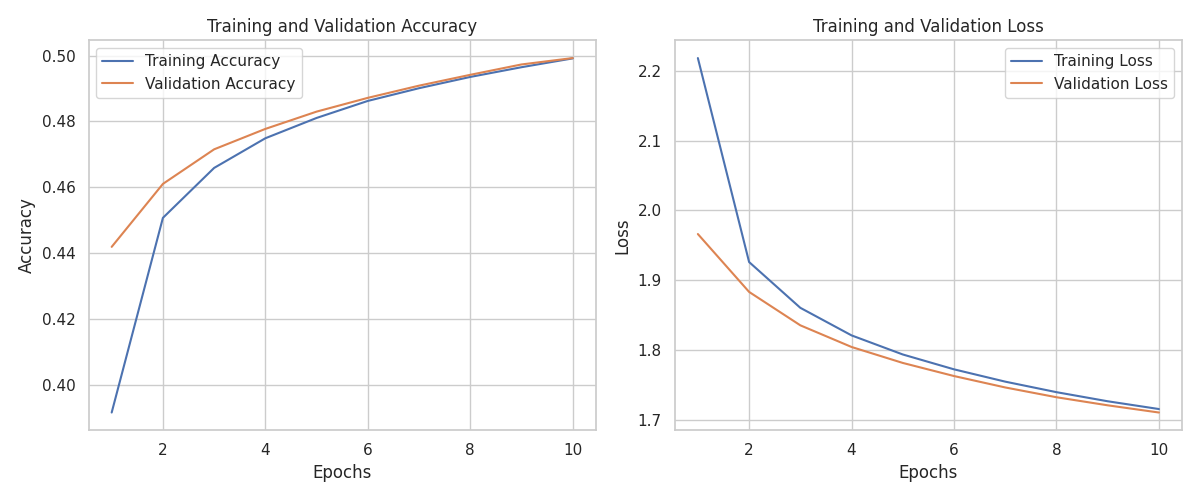

**Narrow and Depper**

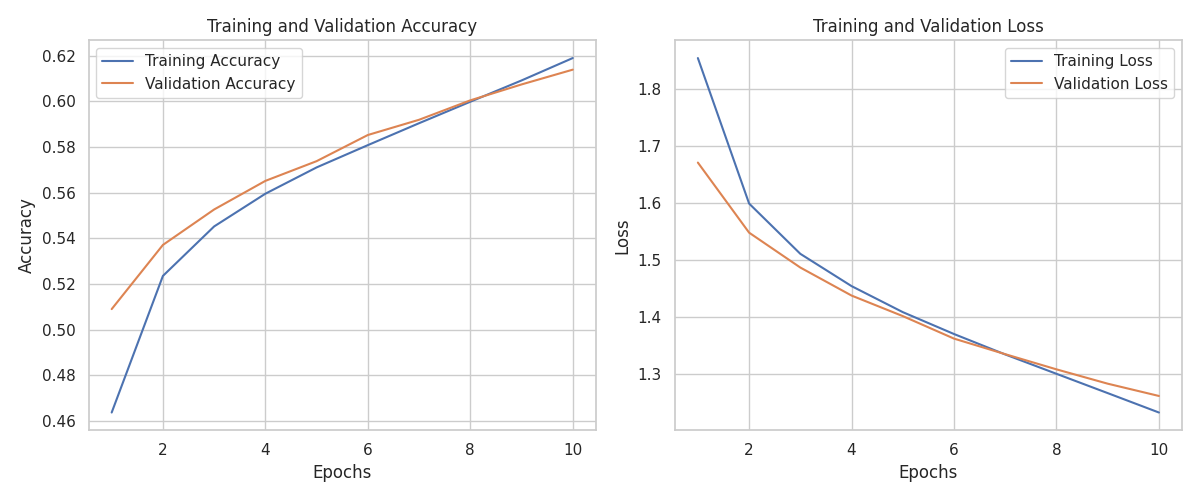

*Notes*
- Starting over fitting after 7tg or 8th epochs.

**wider and shallower**

Typical disadvantage of wide and shallow model:
- Computational Complexity:
    >A wide and shallow network with a vast number of input neurons can result in high computational complexity. Training and making predictions with such networks may be computationally expensive, especially as the number of **parameters increases**.
- Overfitting:
    >Shallow networks may struggle with capturing complex patterns in the data. The model might end up fitting the training data too closely, leading to overfitting. Overfitting occurs when the model performs well on training data but poorly on unseen data.
- Limited Representational Power:
    >Shallow networks might not have enough depth to learn hierarchical representations of features in the data. Deep networks, with multiple hidden layers, are often better suited for **capturing intricate relationships and representations**.
- Feature Extraction Challenges:
    >Wide and shallow networks may face challenges in automatic feature extraction. Deep networks, by design, learn hierarchical features from data, allowing them to automatically **extract and represent meaningful features**.


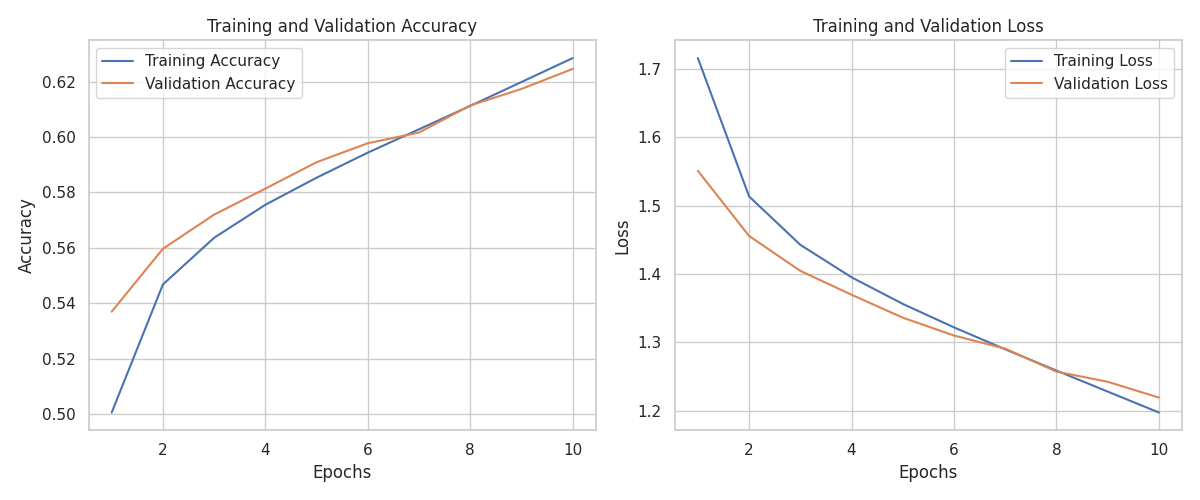

*Notes*

- Here, we only see the time of training is longer than deeper model, which we train last.

**Drop out rate 0.25**

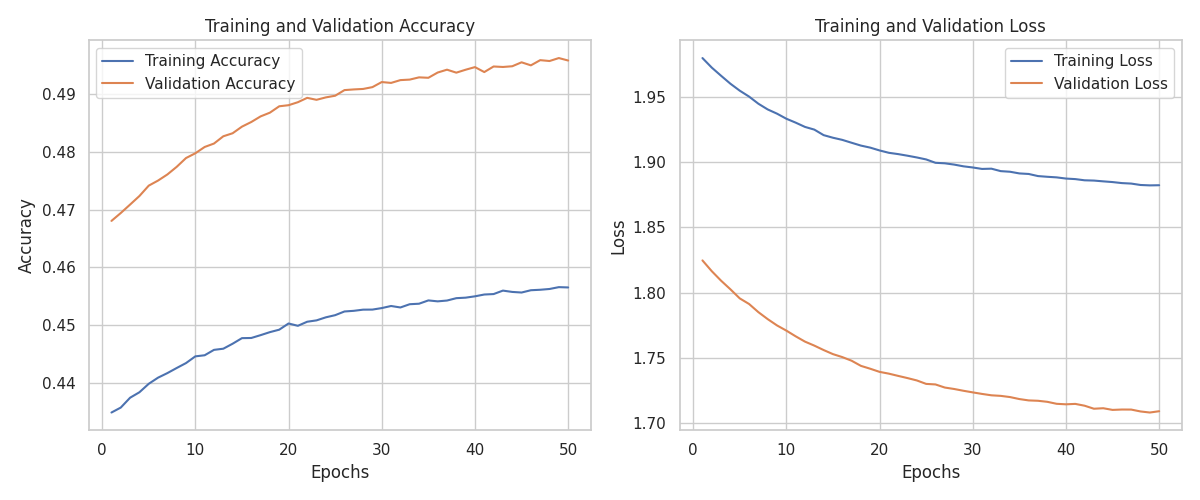

*Notes*

- Because the train set and validation set are not that overlap when we trained, it seems not that easy to overfitting.

**Drop out rate 0.5**

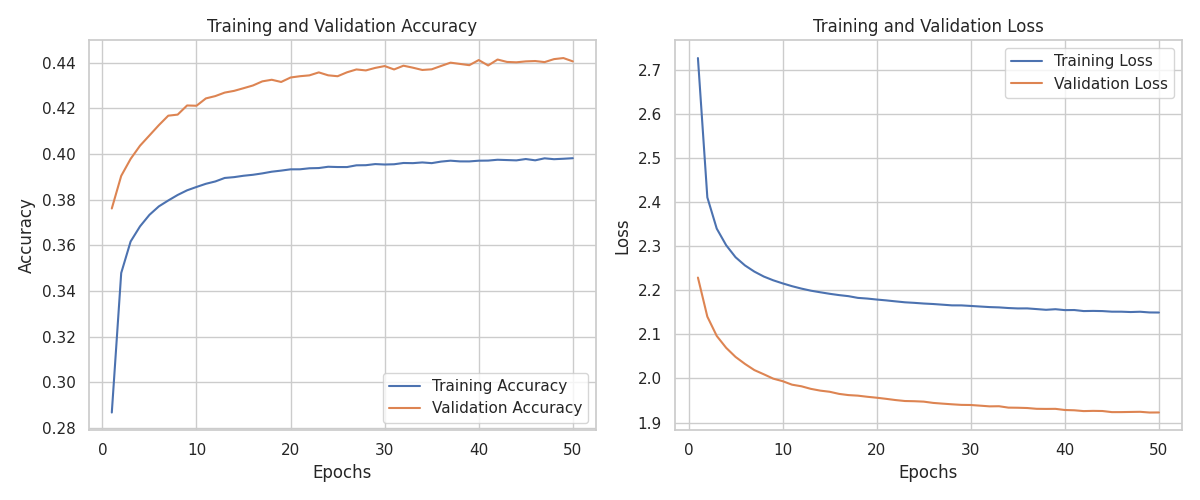

*Notes*

- As we increse the rate, we see it more flater after 20 epochs than 0.25 rate

**Drop out rate 0.75**

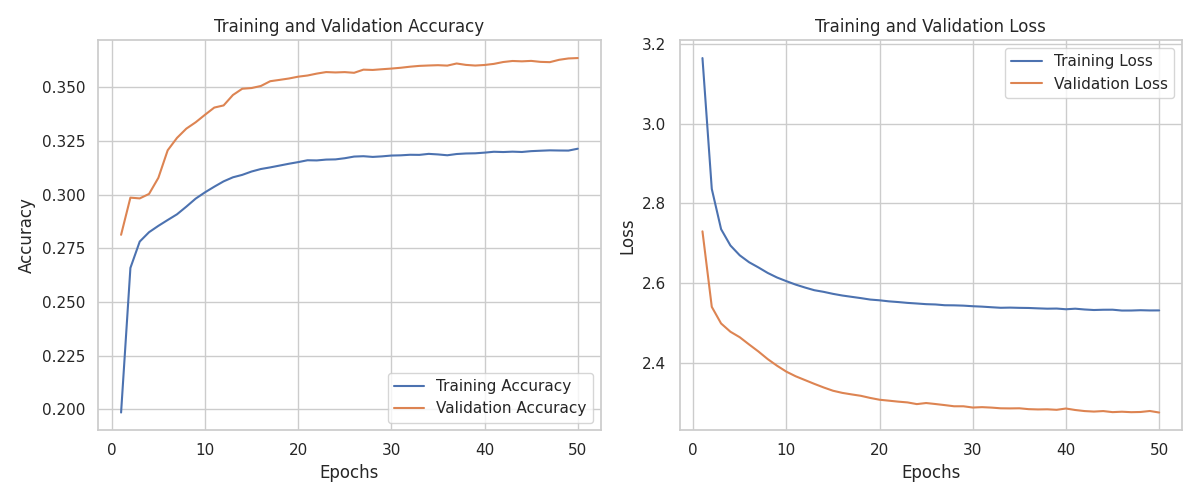

*Notes*

- A big problem is we increse the rate to prevent over fitting, but it will under fitting. 

*Insights*

- We can use deeper and narrow model and deop out to train model.

**drop out rate 0.5 and deep + narrow model**

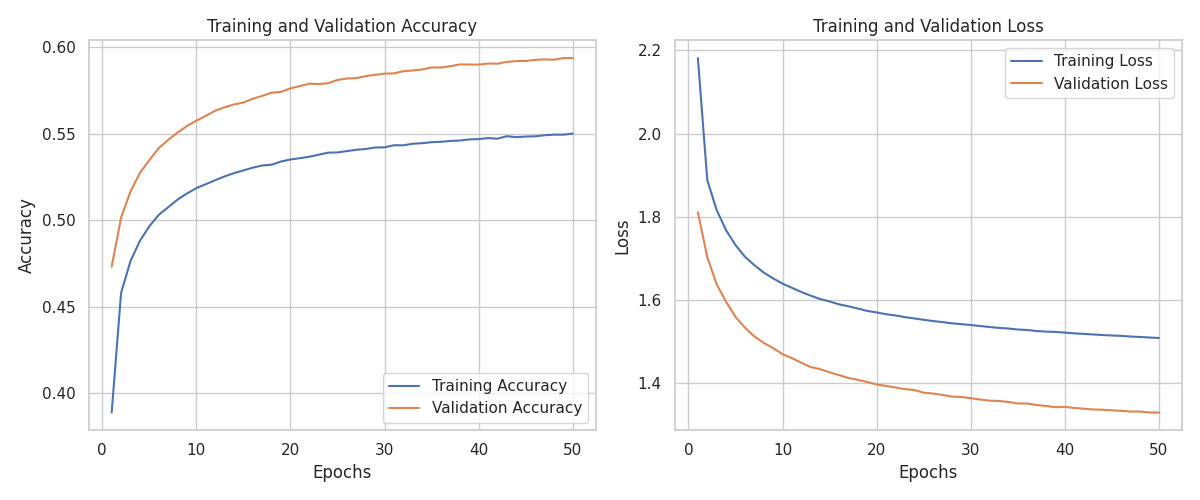

*Notes*

- It doesn't overfitting and the accuracy is the highest so far.

**BN -> ReLU -> Dropout**

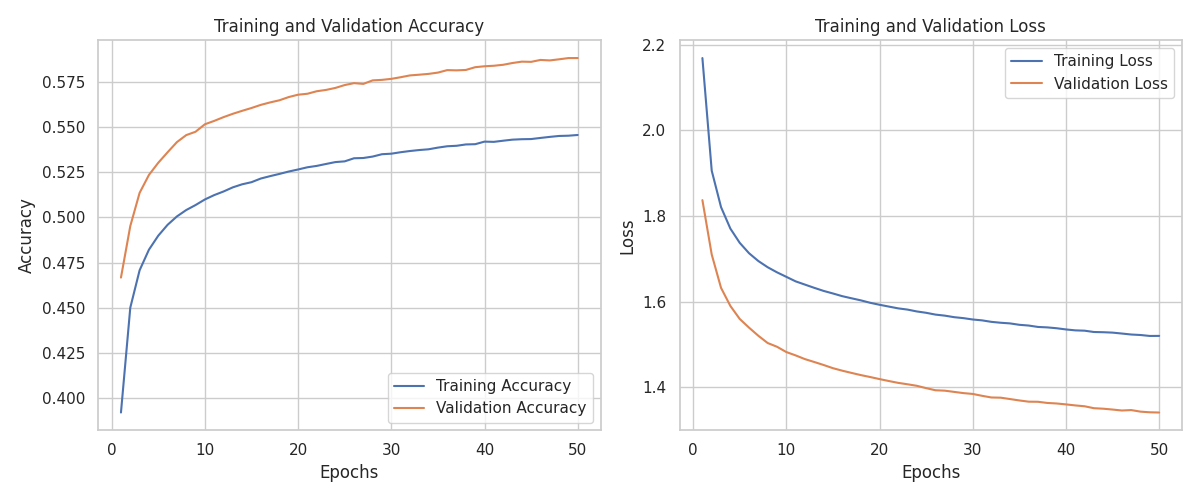

**Linear -> ReLU -> Dropout -> BN -> Linear**

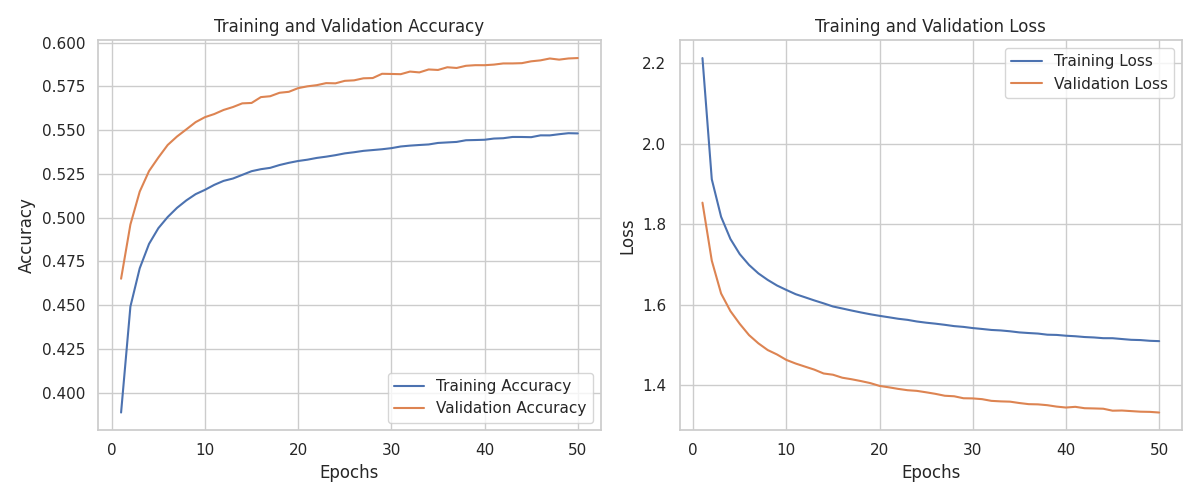

**Concat 5**

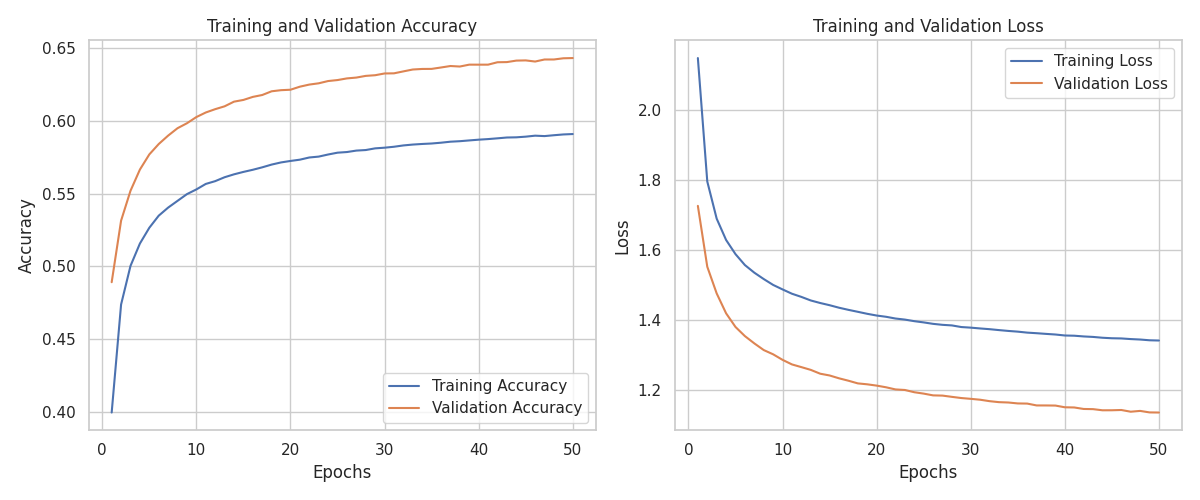

**Concat 7**

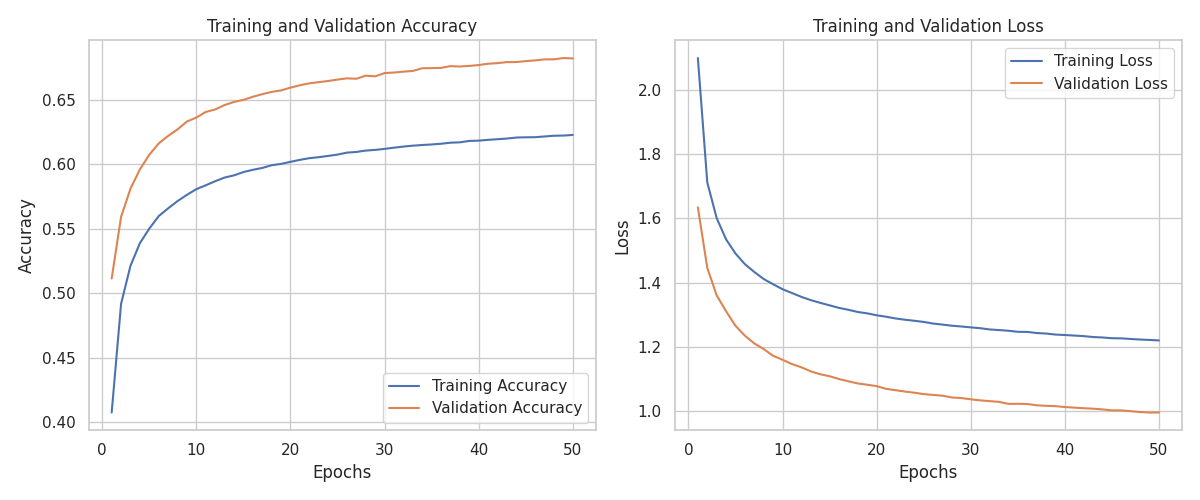